In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [58]:
sns.set()

data = pd.read_csv("ele_train.csv", index_col=1,parse_dates = True)
data.head()

,num,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
date_time,,,,,,,,,
2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,0,0
2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,0,0
2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,0,0
2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,0,0
2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,0,0


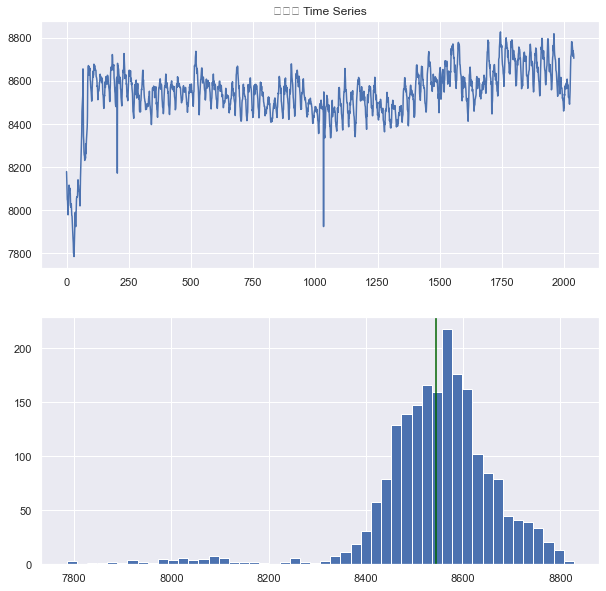

In [32]:
ele = data[data["num"]==1].전력사용량
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
axs[0].set_title("전력량 Time Series")
axs[0].plot(ele)
axs[1].hist(x=ele.values, bins=50)
axs[1].axvline(np.mean(ele), label="0%", color="darkgreen")

이게 뭐냐

C:\Users\phs51\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 51204 (\N{HANGUL SYLLABLE JEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\phs51\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47141 (\N{HANGUL SYLLABLE RYEOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


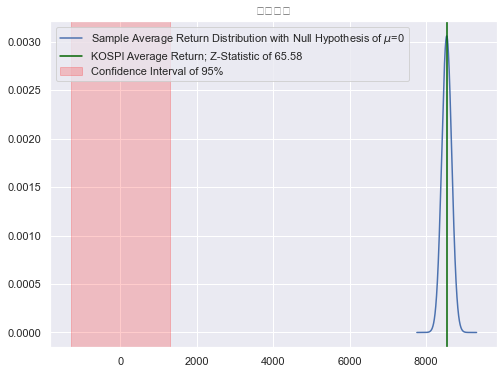

In [42]:
mu = 8543
sigma = ele.std()
x = np.linspace(mu - 6*sigma, mu + 6*sigma, 8000)

plt.figure(figsize=(8,6))
plt.title("전력전력")
plt.plot(x, stats.norm.pdf(x, mu, sigma), label = r"Sample Average Return Distribution with Null Hypothesis of $\mu$=0")
plt.axvline(ele.mean(), color = "darkgreen", label=f"KOSPI Average Return; Z-Statistic of {ele.mean()/sigma:0.2f}")
plt.axvspan(-10*sigma, 10*sigma, label="Confidence Interval of 95%", alpha=0.2, color="red")
plt.legend(loc=2)
plt.show()

???

# 예측을 해보자

<AxesSubplot:title={'center':'up vs down'}>

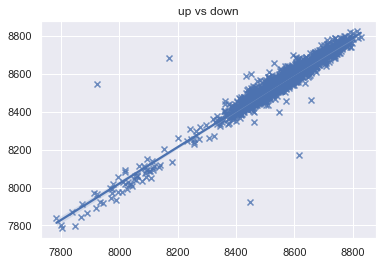

In [44]:
plt.title("up vs down")
sns.regplot(x=ele.values[:-1], y = ele.values[1:], marker="x")

In [48]:
sm.OLS(ele.values[1:], sm.add_constant(ele.values[:-1])).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.927
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                 2.603e+04
Date:                Sat, 28 Jan 2023   Prob (F-statistic):               0.00
Time:                        15:34:01   Log-Likelihood:                -10144.
No. Observations:                2039   AIC:                         2.029e+04
Df Residuals:                    2037   BIC:                         2.030e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        328.8423     50.926      6.457      0.000     228.970     428.714
x1             0.9615      0.006    161.325      0.000       0.950       0.973
==============================================================================
Omnibus:                     1164.027   Durbin-Watson:                   2.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           836745.392
Skew:                           1.265   Prob(JB):                         0.00
Kurtosis:                     102.209   Cond. No.                     5.61e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

상관계수는 높은데 알림[2]를 보니 다중공선성 문제가 있단다. 근데 일변량으로 체크하는데 알림[2]가 왜 뜰까? 내가 통계 지식이 부족한가..

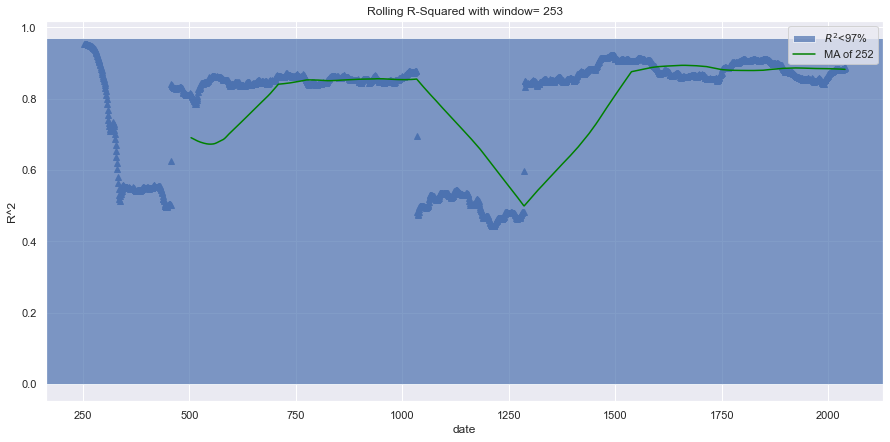

In [52]:
temp = {}

for n in range(len(ele)-253):
    temp[ele.index[n+253]] = ele.iloc[n:n+253].corr(ele.iloc[n:n+253].shift(1))**2

temp = pd.Series(temp)
plt.figure(figsize=(15,7))
plt.title("Rolling R-Squared with window= 253")
plt.plot(temp, "^")

plt.axhspan(0, 0.97, label=r"$R^2$<97%", alpha=0.7)
plt.ylabel(r"R^2")
plt.xlabel("date")
plt.plot(temp.rolling(252).mean(), color="green", label = "MA of 252")
plt.legend()

로쥐스틱 회귀

In [56]:
from itertools import combinations as c

def featureGenerator1(array):
    return [array, array.rolling(20).mean(), array.rolling(20).std(), (array-array.rolling(20).mean())/array.rolling(20).std()]
def multiplier_and_divider(arrays):
    result=[]
    
    for com in c(arrays, 2):
        result.append(com[0]*com[1])
        result.append(com[0]/com[1])
    return result

In [61]:
initial1 =[]
for col in data.columns:
    initial1 += featureGenerator1(data[col])

initial2=[]
for col in data.columns:
    initial2 += multiplier_and_divider([data[col] for col in data.columns])

initial3=[]
for array in initial2:
    initial3 += featureGenerator1(array)

initial2 +=initial1
initial2+=initial3
len(initial2)

features = pd.DataFrame(initial2).T
features["y0"] = ele.shift(-1)
features["y"] = np.where(ele.shift(-1)>0, 1, 0)

features.dropna(inplace=True)

features.head()

648


KeyboardInterrupt: 

허허허

# 60개 건물 각각 전력사용량 그려보기

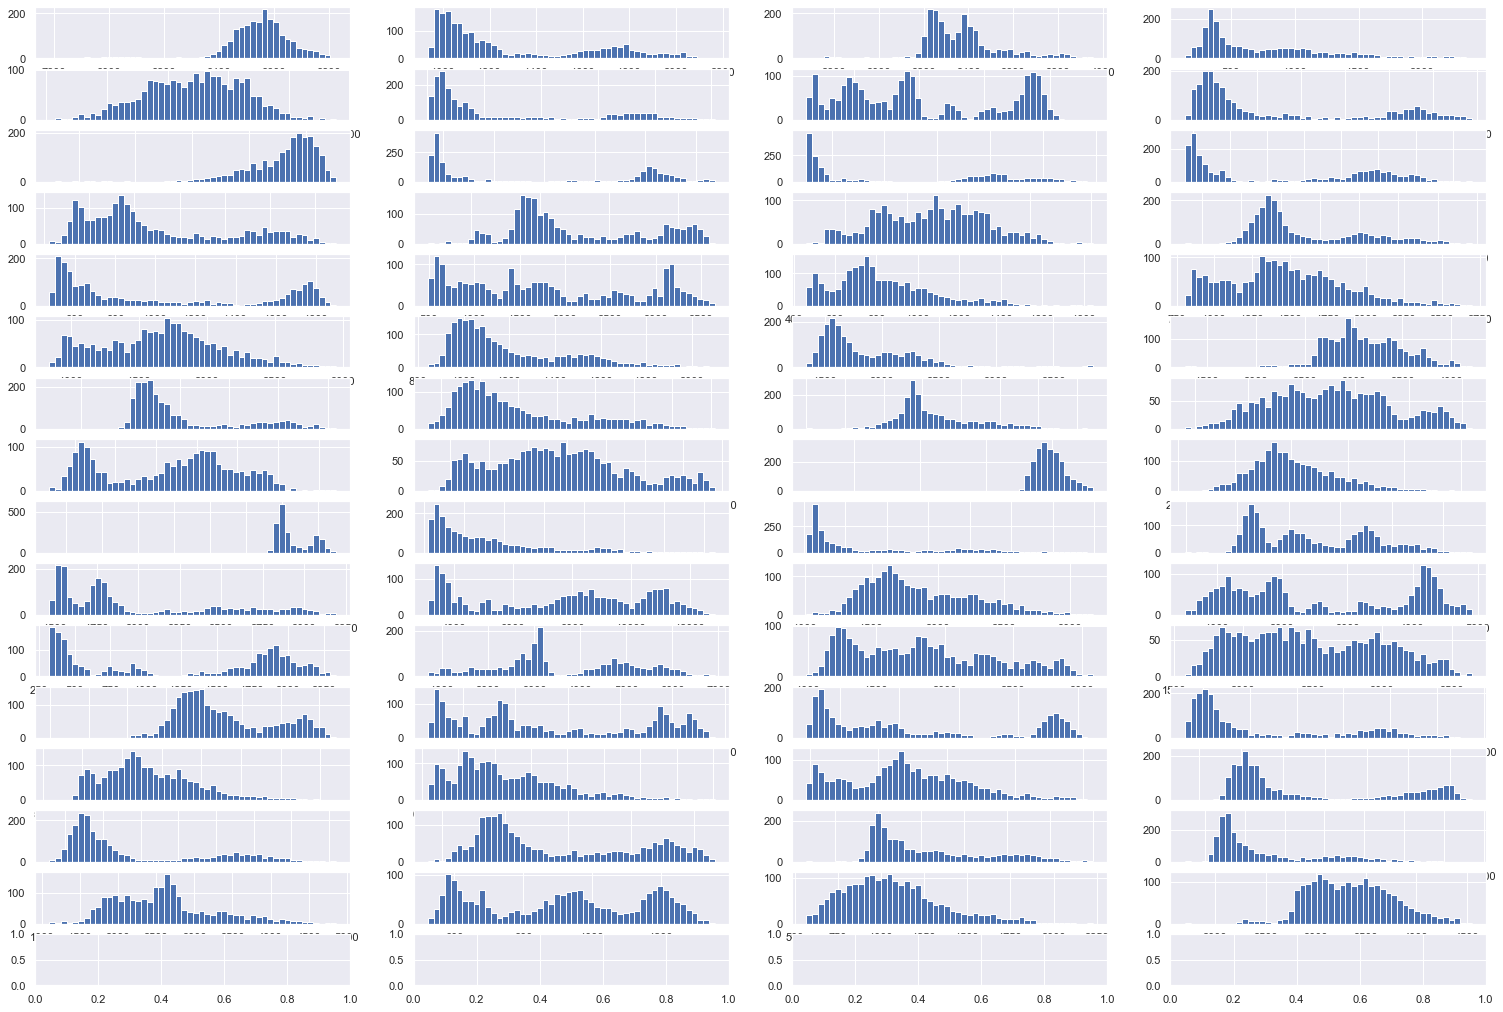

In [71]:
fig, ax = plt.subplots(figsize=(26, 18), ncols=4, nrows=16)

ftrs = [[1]*i for i in range(1,61)]
for i in range(60):
    row = int(i/4)
    col = i%4
    ax[row, col].hist(x=data[data["num"]==i+1].전력사용량, bins=50)

In [72]:
import math
import os
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA

In [75]:
train=pd.read_csv('ele_train.csv')
test = pd.read_csv('test.csv')

train['비전기냉방설비운영'].fillna(0, inplace=True)
train['태양광보유'].fillna(0, inplace=True)
submission = pd.read_csv('sample_submission.csv')

In [76]:
train

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0,0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0,0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0,0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0,0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1,1
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1,1
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1,1
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1,1


60개의 건물 X 85일 24시간 = 122400

In [77]:
test

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [78]:
def df2d_to_array3d(df_2d):#2d의 데이터프레임을 건물별 정보를 반영한 3d 데이터로 (60, 20400,8)
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d['date_time'].value_counts())
    sample_size = len(df_2d.num.value_counts())
    return df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])

In [79]:
train_x_array = df2d_to_array3d(train)
test_x_array = df2d_to_array3d(test)

In [80]:
print(train_x_array.shape)
print(test_x_array.shape)

(60, 2040, 8)
(60, 168, 7)


In [82]:
def plot_series(x_series, y_series):
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series) + len(y_series)), y_series, label = 'output_series')
    plt.axhline(1, c= 'red')
    plt.legend()

In [84]:
idx = 1
x_series = train_x_array[idx, :, 0]
model = ARIMA(x_series, order = (3,0,1))
fit = model.fit()

In [85]:
preds = fit.predict(1, 168, typ='levels')

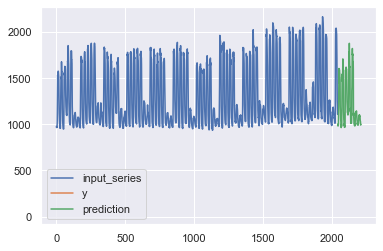

In [87]:
plt.plot(x_series, label = 'input_series')
plt.plot(np.arange(2040, 2040+168), test_x_array[idx, :, 0], label='y')
plt.plot(np.arange(2040, 2040+168), preds, label = 'prediction')
plt.legend()

In [88]:
valid_pred_array=np.zeros([60, 168])
for idx in range(train_x_array.shape[0]):
    try:
        try:
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(5, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
        except:
            print("order 4,1,1")
            
            x_series=train_x_array[idx, :, 0]
            model=ARIMA(x_series, order=(4, 1, 1))
            fit=model.fit()
            preds=fit.predict(1, 168, typ='levels')
            valid_pred_array[idx, :]=preds
    except:
        print(idx, "샘플은 수렴하지 않습니다.")

C:\Users\phs51\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\phs51\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\phs51\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\phs51\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\phs51\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximu

In [89]:
valid_pred_array.shape

(60, 168)

In [90]:
submission['answer'] = valid_pred_array.reshape([-1,1])
submission

,num_date_time,answer
0,1 2020-08-25 00,8177.884037
1,1 2020-08-25 01,8141.515251
2,1 2020-08-25 02,8107.113325
3,1 2020-08-25 03,8048.541587
4,1 2020-08-25 04,8036.527878
...,...,...
10075,60 2020-08-31 19,3139.810899
10076,60 2020-08-31 20,3124.444612
10077,60 2020-08-31 21,3164.565676
10078,60 2020-08-31 22,2996.758219


In [91]:
submission.to_csv('baseline_submission2.csv', index=False)

In [95]:
preds

array([2542.95419666, 2177.89345823, 2292.62768219, 2222.61517857,
       2408.71388493, 2604.91713911, 2895.68018997, 3080.01315949,
       3059.1570125 , 3044.65409309, 3118.9350746 , 2938.13377658,
       2902.01101709, 2870.62333038, 3047.97152245, 3041.04284849,
       3011.26977065, 2885.51056578, 2858.15334571, 2873.3099104 ,
       2876.38999758, 2715.95349564, 2373.58587489, 2773.0368436 ,
       2652.69180352, 2302.61763659, 2208.41209333, 2206.05336316,
       2336.1813606 , 2278.46417519, 2420.67176786, 2957.47801904,
       3371.70121136, 3166.96947148, 3055.70361885, 2954.06986736,
       2931.39907543, 2875.3986364 , 2895.29130289, 2884.92788614,
       3051.69380487, 2907.60525732, 2819.15948317, 2819.57684535,
       2845.69766977, 2899.04313207, 2793.01350694, 2248.49471758,
       2272.23383592, 2258.314361  , 2292.94955604, 2263.42125271,
       2882.34826963, 2984.45170709, 2852.21570058, 2883.17116611,
       3007.65972486, 3104.3320786 , 3066.21006077, 3065.71531